In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from itertools import product
import seaborn as sns
import cleaning
import reinstancing

In [3]:
# Load and reinstance data
df_raw, users = cleaning.loadData('dataset_mood_smartphone.csv')
df_inst = reinstancing.reinstanceDataset(df_raw, users, period=5)
df_inst.head()


AS14.15  cannot provide subusers in ranges
AS14.20  cannot provide subusers in ranges


variable   activity  appCat.builtin  appCat.communication  \
AS14.01 0  0.163560     1370.685667           7502.876667   
        1  0.167999     1052.370500           7612.147000   
        2  0.152443     2607.564833           6929.466167   
        3  0.147191     2718.628833           6510.028333   
        4  0.134610     2643.197000           5181.341000   

variable   appCat.entertainment  appCat.finance  appCat.game  appCat.office  \
AS14.01 0            525.130333       40.585667     0.000000      29.202667   
        1            463.777500       39.364833     0.000000      30.910167   
        2            615.790667       50.713167    38.839333      30.910167   
        3            871.304500       43.479333    38.839333      30.910167   
        4            964.422167       37.795000    38.839333      30.408500   

variable   appCat.other  appCat.social  appCat.travel  appCat.unknown  \
AS14.01 0    125.598667    2597.354500     228.759167       39.203833   
        1     95.395500    2001.834667      84.070667       39.203833   
        2    116.696833    2014.019500     266.688000       39.203833   
        3    132.825333    1942.694333     275.427167       39.203833   
        4    134.066167    1433.370833     205.459667       50.283333   

variable   appCat.utilities  appCat.weather      call  circumplex.arousal  \
AS14.01 0        196.908500        5.064333  3.166667            0.458333   
        1        126.954333        5.064333  2.500000            0.375000   
        2        157.637000        5.064333  2.833333            0.291667   
        3        252.728833        0.000000  3.500000            0.125000   
        4        229.322833        0.000000  1.833333            0.000000   

variable   circumplex.valence      mood        screen       sms  nextday  
AS14.01 0            0.391304  6.416667  13973.567834  0.333333      6.6  
        1            0.478261  6.500000  13884.108333  0.500000      7.0  
        2            0.541667  6.625000  13680.996333  0.333333      6.4  
        3            0.500000  6.541667  13939.128000  0.500000      8.0  
        4            0.708333  6.958333  12185.105167  0.500000      7.5

In [4]:
# Feature engineering
df_feat = df_inst.copy()
df_feat['screen_log'] = np.log1p(df_feat['screen'])
df_feat['activity_log'] = np.log1p(df_feat['activity'])
df_feat['call_sms_ratio'] = df_feat['call'] / (df_feat['sms'] + 1)
df_feat = df_feat.dropna()
df_feat['mood_cat'] = pd.qcut(df_feat['nextday'], 5, labels=False)
df_feat.head()


variable   activity  appCat.builtin  appCat.communication  \
AS14.01 0  0.163560     1370.685667           7502.876667   
        1  0.167999     1052.370500           7612.147000   
        2  0.152443     2607.564833           6929.466167   
        3  0.147191     2718.628833           6510.028333   
        4  0.134610     2643.197000           5181.341000   

variable   appCat.entertainment  appCat.finance  appCat.game  appCat.office  \
AS14.01 0            525.130333       40.585667     0.000000      29.202667   
        1            463.777500       39.364833     0.000000      30.910167   
        2            615.790667       50.713167    38.839333      30.910167   
        3            871.304500       43.479333    38.839333      30.910167   
        4            964.422167       37.795000    38.839333      30.408500   

variable   appCat.other  appCat.social  appCat.travel  ...  \
AS14.01 0    125.598667    2597.354500     228.759167  ...   
        1     95.395500    2001.834667      84.070667  ...   
        2    116.696833    2014.019500     266.688000  ...   
        3    132.825333    1942.694333     275.427167  ...   
        4    134.066167    1433.370833     205.459667  ...   

variable   circumplex.arousal  circumplex.valence      mood        screen  \
AS14.01 0            0.458333            0.391304  6.416667  13973.567834   
        1            0.375000            0.478261  6.500000  13884.108333   
        2            0.291667            0.541667  6.625000  13680.996333   
        3            0.125000            0.500000  6.541667  13939.128000   
        4            0.000000            0.708333  6.958333  12185.105167   

variable        sms  nextday  screen_log  activity_log  call_sms_ratio  \
AS14.01 0  0.333333      6.6    9.544994      0.151485        2.375000   
        1  0.500000      7.0    9.538572      0.155292        1.666667   
        2  0.333333      6.4    9.523836      0.141884        2.125000   
        3  0.500000      8.0    9.542527      0.137316        2.333333   
        4  0.500000      7.5    9.408052      0.126289        1.222222   

variable   mood_cat  
AS14.01 0         1  
        1         1  
        2         0  
        3         4  
        4         3  

[5 rows x 24 columns]

In [5]:
# Prepare train/test split
X = df_feat.drop(columns=['nextday', 'mood_cat'])
y = df_feat['mood_cat']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, stratify=y, random_state=42
 )


In [6]:
# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [7]:
# Random Forest hyperparameter tuning
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50,100,200,300],
    'max_depth':    [None,10,20,30],
    'min_samples_split': [2,5,10],
    'min_samples_leaf':  [1,2,4],
    'max_features': ['auto','sqrt'],
    'bootstrap':    [True, False]
}

grid_rf = GridSearchCV(
    rf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)
grid_rf.fit(X_train_s, y_train)

print('Best RF params:', grid_rf.best_params_)
print('Best RF CV accuracy:', grid_rf.best_score_)
y_pred_rf = grid_rf.best_estimator_.predict(X_test_s)
print(classification_report(y_test, y_pred_rf))

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


KeyboardInterrupt: 

In [ ]:
nnn()


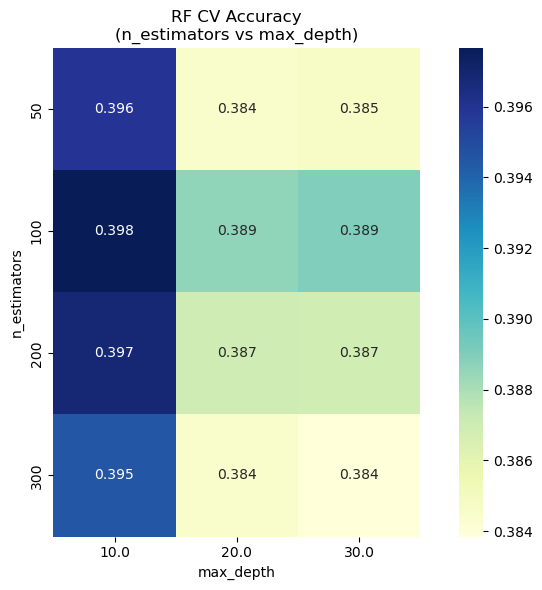

In [ ]:
param_grid = {
    'n_estimators':      [50, 100, 200, 300],
    'max_depth':         [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features':      ['sqrt', 'log2', None],  # dropped 'auto'
    'bootstrap':         [True, False],
}

# Generate every combination
keys, values = zip(*param_grid.items())
combos = [dict(zip(keys, v)) for v in product(*values)]

# Run CV for each combo
results = []
for params in combos:
    rf = RandomForestClassifier(**params, random_state=42)
    scores = cross_val_score(
        rf, X_train_s, y_train,
        cv=3, scoring='accuracy', n_jobs=-1
    )
    results.append({**params, 'mean_score': scores.mean()})

df_res = pd.DataFrame(results)

# Pivot & fill
heatmap_data = (
    df_res
    .pivot_table(
        index='n_estimators',
        columns='max_depth',
        values='mean_score',
        aggfunc='mean'
    )
    .fillna(df_res['mean_score'].min())
)



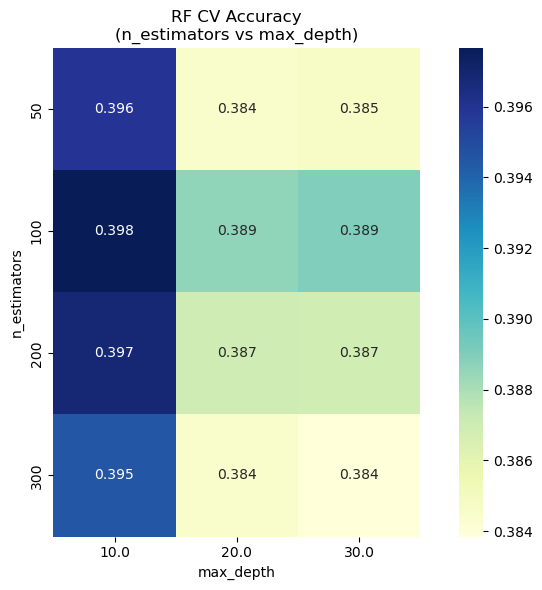

In [ ]:
# Plot
plt.figure(figsize=(8,6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.3f',
    cmap='YlGnBu',
    square=True
)
plt.title("RF CV Accuracy\n(n_estimators vs max_depth)")
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.tight_layout()
plt.show()

c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ...............covariance_type=diag, n_components=2; total time=   0.0s


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

[CV] END ...............covariance_type=diag, n_components=2; total time=   0.1s
[CV] END ...............covariance_type=diag, n_components=2; total time=   0.0s


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

[CV] END ...............covariance_type=diag, n_components=3; total time=   0.0s
[CV] END ...............covariance_type=diag, n_components=3; total time=   0.0s


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

[CV] END ...............covariance_type=diag, n_components=3; total time=   0.0s
[CV] END ...............covariance_type=diag, n_components=4; total time=   0.0s


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

[CV] END ...............covariance_type=diag, n_components=4; total time=   0.1s
[CV] END ...............covariance_type=diag, n_components=4; total time=   0.0s


Model is not converging.  Current: -7354.6498029468585 is not greater than -7354.649789087579. Delta is -1.3859279533789959e-05
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Model is not converging.  Current: -2130.4294573948077 is not greater than -2130.426804043893. Delta is -0.002653350914897601
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Model is not converging.  Current: -5414.828805746729 is not greater than -5414.824709824696. Delta is -0.004095922033229726
c:\Users\Luca

[CV] END ...............covariance_type=diag, n_components=5; total time=   0.1s
[CV] END ...............covariance_type=diag, n_components=5; total time=   0.1s


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Model is not converging.  Current: -5273.925645636305 is not greater than -5273.918854336993. Delta is -0.006791299311771581
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable

[CV] END ...............covariance_type=diag, n_components=5; total time=   0.1s
[CV] END ...............covariance_type=full, n_components=2; total time=   0.0s


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

[CV] END ...............covariance_type=full, n_components=2; total time=   0.1s
[CV] END ...............covariance_type=full, n_components=2; total time=   0.0s


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Model is not converging.  Current: -6387.8288800986165 is not greater than -6387.82854781086. Delta is -0.00033228775646421127
Fitting a model with 833 free scalar parameters with only 616 data points will result in a degenerate solution.
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows

[CV] END ...............covariance_type=full, n_components=3; total time=   0.1s
[CV] END ...............covariance_type=full, n_components=3; total time=   0.1s


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Model is not converging.  Current: -4195.240915967313 is not greater than -4195.240914615507. Delta is -1.3518065316020511e-06
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Fitting a model with 833 free scalar parameters with only 660 data points will result in a degenerate solution.
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows

[CV] END ...............covariance_type=full, n_components=3; total time=   0.2s


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

[CV] END ...............covariance_type=full, n_components=4; total time=   0.1s


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Fitting a model with 1115 free scalar parameters with only 660 data points will result i

[CV] END ...............covariance_type=full, n_components=4; total time=   0.1s


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Model is not converging.  Current: -1626.7045374097295 is not greater than -1626.652255715542. Delta is -0.052281694187513494
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variabl

[CV] END ...............covariance_type=full, n_components=4; total time=   0.1s


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Fitting a model with 1399 free scalar parameters with only 704 data points will result in a degenerate solution.
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THR

[CV] END ...............covariance_type=full, n_components=5; total time=   0.1s


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Model is not converging.  Current: -4428.383868779391 is not greater than -4428.38192078

[CV] END ...............covariance_type=full, n_components=5; total time=   0.1s


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Model is not converging.  Current: -9071.034160498153 is not greater than -9071.03396367459. Delta is -0.00019682356287376024
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variabl

[CV] END ...............covariance_type=full, n_components=5; total time=   0.1s
Best parameters: {'covariance_type': 'diag', 'n_components': 2}
Best cross-validation accuracy: 0.3070134575569358


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


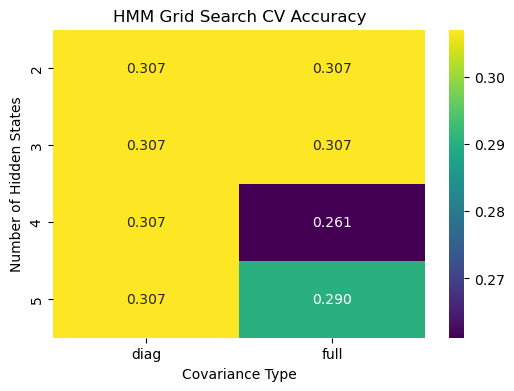

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

# Custom wrapper for sklearn compatibility
class HMMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=2, covariance_type='diag'):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.models_ = {}

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.models_ = {}
        for label in self.classes_:
            model = GaussianHMM(n_components=self.n_components, covariance_type=self.covariance_type, n_iter=100)
            X_label = X[y == label]
            model.fit(X_label)
            self.models_[label] = model
        return self

    def predict(self, X):
        scores = np.zeros((X.shape[0], len(self.classes_)))
        for idx, label in enumerate(self.classes_):
            scores[:, idx] = self.models_[label].score_samples(X)[0]
        return self.classes_[np.argmax(scores, axis=1)]

# Hyperparameter grid
param_grid = {
    'n_components': [2, 3, 4, 5],
    'covariance_type': ['diag', 'full']
}

# Run grid search
hmm_clf = HMMClassifier()
grid_search = GridSearchCV(hmm_clf, param_grid, cv=3, scoring='accuracy', verbose=2, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Prepare data for heatmap
results = pd.DataFrame(grid_search.cv_results_)
heatmap_data = results.pivot(index='param_n_components', columns='param_covariance_type', values='mean_test_score')

plt.figure(figsize=(6,4))
import seaborn as sns
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title("HMM Grid Search CV Accuracy")
plt.ylabel("Number of Hidden States")
plt.xlabel("Covariance Type")
plt.show()

# RNN hyperparameter tuning


In [ ]:
# Prepare data for RNN
X_train_rnn = X_train_s.reshape((X_train_s.shape[0], 1, X_train_s.shape[1]))
X_test_rnn = X_test_s.reshape((X_test_s.shape[0], 1, X_test_s.shape[1]))


In [ ]:
# RNN hyperparameter tuning
n_features = X_train_s.shape[1]
def create_model(units=64, dropout_rate=0.5, optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(units, activation='relu', input_shape=(1, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(5, activation='softmax'))
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model
rnn = KerasClassifier(build_fn=create_model, verbose=0)
param_grid_rnn = {
    'units': [32,64],
    'dropout_rate': [0.2,0.5],
    'optimizer': ['adam','rmsprop'],
    'batch_size': [16,32],
    'epochs': [10,20]
}

grid_rnn = GridSearchCV(
    rnn,
    param_grid=param_grid_rnn,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=1
)
grid_rnn.fit(X_train_rnn, y_train)
print('Best RNN params:', grid_rnn.best_params_)
print('Best RNN CV accuracy:', grid_rnn.best_score_)
